In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-19 12:46:57.149379: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 12:46:57.173744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-19 12:46:58.367540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:46:58.371342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:46:58.371462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:

dataset_name = 'crypto_day'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params



Using output folder .


2023-11-19 12:46:58.404694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:46:58.404832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:46:58.404933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 160
learning_rate: 0.01
minibatch_size: 32
max_gradient_norm: 0.01
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 160
# learning_rate = 0.01
# max_gradient_norm = 0.01
# minibatch_size = 32
# model_folder = ./saved_models/crypto_day/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_V

2023-11-19 12:46:58.993089: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:46:58.995992: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-19 12:46:59.194393: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_11/kernel/Assign' id:418 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_11/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_11/kernel, TemporalFusionTransformer/dense_11/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:46:59.210478: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape:

2023-11-19 12:46:59.669637: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:46:59.686919: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/kernel/Assign' id:1428 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/kernel, TemporalFusionTransformer/time_distributed_7/k

2023-11-19 12:47:00.400232: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:2396 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:00.496038: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_29/kernel/Assign' id:2454 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_29/kernel, TemporalFusionTransforme

2023-11-19 12:47:01.318259: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:3246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:01.357287: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm/kernel/Assign' id:3262 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm/kernel, TemporalFusionTransformer/cu_dnnlstm/kernel/Initializer

2023-11-19 12:47:02.301971: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_22/stack_2' id:3915 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_22/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:02.347961: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack' id:3908 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 31, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 1, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 1, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 1, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 1, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 160)                  320       ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 31, 160)              320       ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 31, 160)              0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

2023-11-19 12:47:03.287322: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_19/beta/Assign' id:4500 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_19/beta, TemporalFusionTransformer/layer_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 870 samples, validate on 107 samples


2023-11-19 12:47:05.317823: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:05.647319: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/dense_22/bias/v/Assign' id:9534 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/dense_22/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransformer/dense_22/bias/v, trai

Epoch 1/100


2023-11-19 12:47:08.372923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-19 12:47:08.486860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


864/870 [============================>.] - ETA: 0s - loss: 94.6279 - mae: 1.5549 - mse: 5.6647 - f1_metric: 0.3746 

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-19 12:47:09.305464: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 4s 5ms/sample - loss: 93.9930 - mae: 1.5518 - mse: 5.6396 - f1_metric: 0.3850 - val_loss: 38.2117 - val_mae: 0.9504 - val_mse: 1.0876 - val_f1_metric: 1.7423e-08
Epoch 2/100
870/870 [==============================] - 1s 819us/sample - loss: 11.5039 - mae: 1.0039 - mse: 1.9082 - f1_metric: 0.4209 - val_loss: 3.3335 - val_mae: 0.7024 - val_mse: 0.7188 - val_f1_metric: 1.9028e-08
Epoch 3/100
870/870 [==============================] - 1s 705us/sample - loss: 10.6629 - mae: 0.8789 - mse: 1.4314 - f1_metric: 0.3711 - val_loss: 6.6581 - val_mae: 0.5927 - val_mse: 0.4885 - val_f1_metric: 1.9454e-08
Epoch 4/100
870/870 [==============================] - 1s 821us/sample - loss: 13.5042 - mae: 0.7983 - mse: 1.2107 - f1_metric: 0.3700 - val_loss: 2.2552 - val_mae: 0.3088 - val_mse: 0.1515 - val_f1_metric: 1.7549e-08
Epoch 5/100
870/870 [==============================] - 1s 707us/sample - loss: 9.7332 - mae: 0.7020 - mse: 0.9527 - f1_metric: 0.4102 - val_l

2023-11-19 12:47:19.557113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:47:19.557288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:47:19.557712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-19 12:47:19.770703: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:19.777003: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_2' id:478 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mut

2023-11-19 12:47:20.488737: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_14/bias/Assign' id:1725 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_14/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_14/bias, TemporalFusionTransformer/time_distributed_14/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:20.524519: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_15/stack_1' id:1816 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_15/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-19 12:47:21.388997: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_12/stack' id:296 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_12/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 30 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:21.420739: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_12/stack_1' id:297 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_12/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 0 0>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-19 12:47:22.373494: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_48/kernel/Assign' id:3715 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_48/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_48/kernel, TemporalFusionTransformer/time_distributed_48/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:47:22.536876: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_16/beta/Assign' id:3869 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_16/beta/Assign}} = AssignVariableOp[_has_manu

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 31, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 1, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 1, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 1, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 1, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 160)                  320       ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 31, 160)              320       ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 31, 160)              0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

[ 0.0951874   0.19463238  0.13261911 -0.35494456  0.10978109  0.23896529
 -0.1686003  -0.04274503  0.05591178 -0.0237643   0.19004643 -0.18160912
  0.16500674 -0.13539939  0.21759148 -0.09750503  0.12680845  0.14730133
  0.19940554  0.26951373 -0.28629518  0.04184153 -0.24505639  0.23359041
 -0.24690174  0.14808996 -0.08398361 -0.06045266  0.02510146  0.15086308
  0.15088229 -0.01928444  0.06159824 -0.18216823  0.07772444 -0.00579181
  0.1416356  -0.2276783  -0.27832973 -0.00569705 -0.11577711  0.05709067
  0.16194543  0.26452205 -0.08004453  0.3322995  -0.28127432 -0.28538224
  0.0289101  -0.03519417 -0.11608009  0.11018208  0.16273251 -0.16673744
 -0.07122104 -0.0755216   0.22302856 -0.13189813 -0.12401298  0.14384027
 -0.17325476  0.19500136  0.07069841 -0.20365073  0.15708177 -0.02185784
 -0.17203413 -0.14377637 -0.08545659  0.12633838 -0.16684498  0.10055351
 -0.21965067  0.20688787 -0.2610048  -0.15610647 -0.04221086 -0.14915965
  0.01021571  0.26899582 -0.28374135 -0.24566706  0

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day/fixed/TemporalFusionTransformer.ckpt


2023-11-19 12:47:23.812740: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/total_1/Assign' id:4624 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/total_1, TemporalFusionTransformer/total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-19 12:47:24.147118: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-19 12:47:24.615553: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/Reshape_1' id:4607 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_61/dense_91/BiasAdd, TemporalFusionTransformer/time_distributed_61/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-19 12:47:24.946985
Best validation loss = 6.44319685374465
Params:
dropout_rate  =  0.3
hidden_layer_size  =  160
learning_rate  =  0.01
max_gradient_norm  =  0.01
minibatch_size  =  32
model_folder  =  ./saved_models/crypto_day/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  10
multiprocessing_workers  =  10
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPU

In [4]:
output_map

{'results': array([[[-0.3016128 , -0.37041506, -0.91233045]],
 
        [[-0.31934726, -0.3788717 , -0.93251646]],
 
        [[-0.43052214, -0.46290424, -1.1639415 ]],
 
        [[-0.43047082, -0.46199027, -1.1619529 ]],
 
        [[-0.4305247 , -0.46273825, -1.163587  ]],
 
        [[-0.32958376, -0.5190394 , -1.1337804 ]],
 
        [[-0.36332145, -0.50078845, -1.1657741 ]],
 
        [[-0.30653855, -0.53124344, -1.1104455 ]],
 
        [[-0.39385444, -0.4843708 , -1.1859431 ]],
 
        [[-0.34926412, -0.39045033, -0.9621603 ]],
 
        [[-0.3757706 , -0.4035432 , -0.9936007 ]],
 
        [[-0.36443356, -0.39686993, -0.9778087 ]],
 
        [[-0.35603198, -0.3445497 , -0.9250593 ]],
 
        [[-0.29826283, -0.3564197 , -0.89211243]],
 
        [[-0.29245415, -0.35906145, -0.89116526]],
 
        [[-0.3308615 , -0.34850338, -0.9104168 ]],
 
        [[-0.29234284, -0.35916927, -0.8912297 ]],
 
        [[-0.34919363, -0.34533507, -0.9217825 ]],
 
        [[-0.35290408, -0.34492218,

In [9]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.370415,-0.594439
1,-0.378872,-0.594136
2,-0.462904,-0.594912
3,-0.461990,-0.617858
4,-0.462738,-0.613765
5,-0.519039,-0.619840
6,-0.500788,-0.609206
7,-0.531243,-0.562660
8,-0.484371,-0.570610
9,-0.390450,-0.566570


<Axes: >

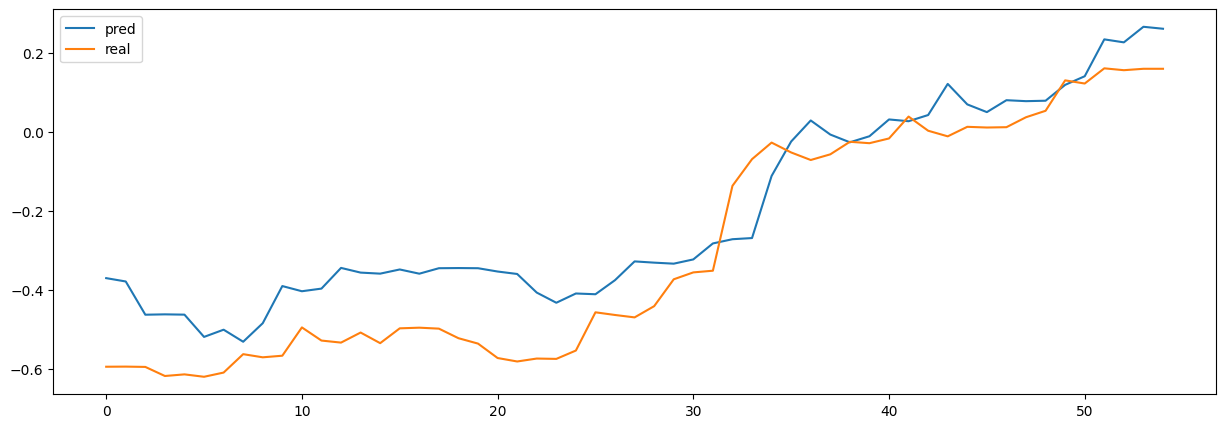

In [10]:
test_df.plot(figsize=(15,5))